<a href="https://colab.research.google.com/github/AImSecure/Laboratory3/blob/main/lab/notebooks/Lab3_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory 3 — Anomaly Detection

text

## Setup

In [73]:
# --- Check Python and pip versions ---
!python --version
!pip install --upgrade pip

Python 3.12.12


In [74]:

# --- Install required libraries ---
!pip install torch
!pip install numpy pandas scikit-learn matplotlib seaborn
!pip install tqdm

In [75]:
# --- Import libraries ---
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from tqdm import tqdm

### Colab Pro

In [76]:
# --- Check GPU availability ---
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [77]:
# --- Check RAM availability ---
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


### Paths setup


In [78]:
# --- Mount Google Drive (for Google Colab users) ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
# --- Define Paths ---
group = 'AImSecure'
laboratory = 'Laboratory3'

base_path = '/content/drive/MyDrive/'
project_path = base_path + f'Projects/{group}/{laboratory}/'
data_path = project_path + 'data/'
results_path = project_path + 'results/'

# Ensure directories exist
os.makedirs(project_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)
os.makedirs(results_path, exist_ok=True)

print(f"Project path: {project_path}")
print(f"Data path: {data_path}")
print(f"Results path: {results_path}")

Project path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/
Data path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/data/
Results path: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/


In [80]:
# --- Set visual style ---
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

def save_plot(fig: plt.Figure, filename: str, path: str = "./plots/", fmt: str = "png", dpi: int = 300, close_fig: bool = False) -> None:
    """
    Save a Matplotlib figure in a specific to a specified directory.

    Args:
        fig (plt.Figure): Matplotlib figure object to save.
        filename (str): Name of the file to save (e.g., 'plot.png').
        path (str, optional): Directory path to save the figure. Defaults to './plots/'.
        fmt (str, optional): File format for the saved figure. Defaults to 'png'.
        dpi (int, optional): Dots per inch for the saved figure. Defaults to 300.

    Returns:
        None
    """
    # Ensure the directory exists
    os.makedirs(path, exist_ok=True)
    save_path = os.path.join(path, f"{filename}.{fmt}")

    # Save the figure
    fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1, dpi=dpi, format=fmt)
    # plt.close(fig) # Removed to display plots in notebook

    if close_fig:
        plt.close(fig)

    print(f"Saved plot: {save_path}")

## Task 1 — Dataset Characterization and Preprocessing

text


In [81]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task1_plots/'
os.makedirs(save_dir, exist_ok=True)

### Explore the dataset

Before preprocessing, we explore the data to understand the available features.

In [82]:
# --- Load Datasets ---

train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')

print("Files loaded successfully.")
print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape:  {test_df.shape}")

Files loaded successfully.
Train dataset shape: (18831, 43)
Test dataset shape:  (5826, 43)


In [83]:
train_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,28,0,0,3,0,0,...,0.36,0.65,0.36,0.00,0.09,0.0,0.56,0.0,dos,1
1,0,icmp,eco_i,SF,8,0,0,0,0,0,...,1.00,0.00,1.00,0.50,0.00,0.0,0.00,0.0,probe,1
2,0,tcp,daytime,S0,0,0,0,0,0,0,...,0.02,0.05,0.00,0.00,1.00,1.0,0.00,0.0,dos,1
3,0,tcp,http,SF,216,3396,0,0,0,0,...,1.00,0.00,0.14,0.02,0.00,0.0,0.00,0.0,normal,0
4,0,tcp,http,SF,348,277,0,0,0,0,...,1.00,0.00,0.01,0.07,0.00,0.0,0.00,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18826,0,tcp,http,SF,328,1231,0,0,0,0,...,1.00,0.00,0.02,0.02,0.00,0.0,0.00,0.0,normal,0
18827,0,tcp,http,SF,214,928,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0,normal,0
18828,0,tcp,http,SF,253,11905,0,0,0,0,...,1.00,0.00,0.01,0.02,0.00,0.0,0.00,0.0,normal,0
18829,0,tcp,uucp_path,S0,0,0,0,0,0,0,...,0.05,0.07,0.00,0.00,1.00,1.0,0.00,0.0,dos,1


In [84]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18831 entries, 0 to 18830
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     18831 non-null  int64  
 1   protocol_type                18831 non-null  object 
 2   service                      18831 non-null  object 
 3   flag                         18831 non-null  object 
 4   src_bytes                    18831 non-null  int64  
 5   dst_bytes                    18831 non-null  int64  
 6   land                         18831 non-null  int64  
 7   wrong_fragment               18831 non-null  int64  
 8   urgent                       18831 non-null  int64  
 9   hot                          18831 non-null  int64  
 10  num_failed_logins            18831 non-null  int64  
 11  logged_in                    18831 non-null  int64  
 12  num_compromised              18831 non-null  int64  
 13  root_shell      

In [85]:
test_df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,binary_label
0,0,udp,private,SF,1,0,0,0,0,0,...,0.03,0.85,1.00,0.0,0.0,0.0,0.0,0.0,normal,0
1,0,udp,private,SF,55,51,0,0,0,0,...,1.00,0.00,0.99,0.0,0.0,0.0,0.0,0.0,normal,0
2,0,tcp,login,RSTO,0,0,0,0,0,0,...,0.07,0.06,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
3,0,tcp,ftp,S0,0,0,0,0,0,0,...,0.00,0.11,0.00,0.0,1.0,1.0,0.0,0.0,dos,1
4,0,tcp,courier,REJ,0,0,0,0,0,0,...,0.07,0.05,0.00,0.0,0.0,0.0,1.0,1.0,dos,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5821,0,udp,domain_u,SF,46,85,0,0,0,0,...,1.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5822,0,udp,domain_u,SF,45,45,0,0,0,0,...,0.89,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal,0
5823,0,udp,domain_u,SF,44,79,0,0,0,0,...,1.00,0.00,0.01,0.0,0.0,0.0,0.0,0.0,normal,0
5824,0,udp,private,SF,54,52,0,0,0,0,...,1.00,0.00,0.84,0.0,0.0,0.0,0.0,0.0,normal,0


In [86]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5826 entries, 0 to 5825
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     5826 non-null   int64  
 1   protocol_type                5826 non-null   object 
 2   service                      5826 non-null   object 
 3   flag                         5826 non-null   object 
 4   src_bytes                    5826 non-null   int64  
 5   dst_bytes                    5826 non-null   int64  
 6   land                         5826 non-null   int64  
 7   wrong_fragment               5826 non-null   int64  
 8   urgent                       5826 non-null   int64  
 9   hot                          5826 non-null   int64  
 10  num_failed_logins            5826 non-null   int64  
 11  logged_in                    5826 non-null   int64  
 12  num_compromised              5826 non-null   int64  
 13  root_shell        

In [87]:
# --- Identify Categorical and Numerical Features ---

# We exclude the label columns from the feature lists
label_cols = ['label', 'binary_label']

# Identify categorical columns (type 'object')
categorical_cols = train_df.select_dtypes(include=['object']).columns.to_list()

# Identify numerical columns (any number type)
numerical_cols = train_df.select_dtypes(include=np.number).columns.drop(label_cols, errors='ignore').to_list()

print(f"\n--- Feature Types ---")
print(f"Categorical features: {categorical_cols}")
print(f"Numerical features: {len(numerical_cols)} (First 5: {numerical_cols[:5]}...)")
print(f"Label features: {label_cols}")


--- Feature Types ---
Categorical features: ['protocol_type', 'service', 'flag', 'label']
Numerical features: 38 (First 5: ['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment']...)
Label features: ['label', 'binary_label']


In [88]:
# --- Check Label Distribution ---
print("\n--- Attack Label Distribution (Train) ---")
print(train_df['label'].value_counts(normalize=True) * 100)

print("\n--- Binary Label Distribution (Train) ---")
print(train_df['binary_label'].value_counts(normalize=True) * 100)

print("\n--- Attack Label Distribution (Test) ---")
print(test_df['label'].value_counts(normalize=True) * 100)

print("\n--- Binary Label Distribution (Test) ---")
print(test_df['binary_label'].value_counts(normalize=True) * 100)


--- Attack Label Distribution (Train) ---
label
normal    71.414158
dos       15.469173
probe     12.155488
r2l        0.961181
Name: proportion, dtype: float64

--- Binary Label Distribution (Train) ---
binary_label
0    71.414158
1    28.585842
Name: proportion, dtype: float64

--- Attack Label Distribution (Test) ---
label
dos       44.232750
normal    36.937865
probe     18.829386
Name: proportion, dtype: float64

--- Binary Label Distribution (Test) ---
binary_label
1    63.062135
0    36.937865
Name: proportion, dtype: float64


#### Q: What are the dataset characteristics? How many categorical and numerical attributes do you have? How are your attack labels and binary label distributed?

TODO

### Preprocessing

Preprocess features before performing any AI/ML algorithms.

In [89]:
# Make copies to avoid SettingWithCopyWarning
train_proc_df = train_df.copy()
test_proc_df = test_df.copy()

In [90]:
# --- Preprocess Numerical Data: Standardization ---

# We use StandardScaler to scale numerical features
scaler = StandardScaler()

# Fit on training data *only*
train_proc_df[numerical_cols] = scaler.fit_transform(train_proc_df[numerical_cols])
# Transform test data using the *same* scaler
test_proc_df[numerical_cols] = scaler.transform(test_proc_df[numerical_cols])

print("Numerical features standardized.")

Numerical features standardized.


In [91]:
# --- Preprocess Categorical Data: One-Hot Encoding ---

# We use pd.get_dummies for simplicity
train_proc_df = pd.get_dummies(train_proc_df, columns=categorical_cols, dummy_na=False)
test_proc_df = pd.get_dummies(test_proc_df, columns=categorical_cols, dummy_na=False)

# Align columns: This ensures both dataframes have the exact same OHE columns
# If a category was in train but not test, test gets a column of 0s (and vice-versa)
train_aligned, test_aligned = train_proc_df.align(test_proc_df, join='inner', axis=1, fill_value=0)

print("Categorical features one-hot encoded and aligned.")

Categorical features one-hot encoded and aligned.


In [92]:
# --- Separate Features (X) and Labels (y) ---

# The 'align' operation might have dropped the label columns, so we re-take them
# from the original dataframes.

# Get the list of common feature columns after alignment
feature_cols = train_aligned.columns.drop(label_cols, errors='ignore')

# Create final processed feature matrices
X_train = train_aligned[feature_cols]
X_test = test_aligned[feature_cols]

# Create label vectors
y_train_attack = train_df['label']
y_train_binary = train_df['binary_label']
y_test_attack = test_df['label']
y_test_binary = test_df['binary_label']

print("\n--- Final Processed Data Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train_binary shape: {y_train_binary.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test_binary shape:  {y_test_binary.shape}")


--- Final Processed Data Shapes ---
X_train shape: (18831, 114)
y_train_binary shape: (18831,)
X_test shape:  (5826, 114)
y_test_binary shape:  (5826,)


#### Q: How do you preprocess categorical and numerical data?

TODO

### Study your data from a domain expert perspective

We will plot heatmaps that describe the statistical characteristics of each feature for each attack label. We consider 0/1 features as numerical.

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/task1_mean_heatmap.png


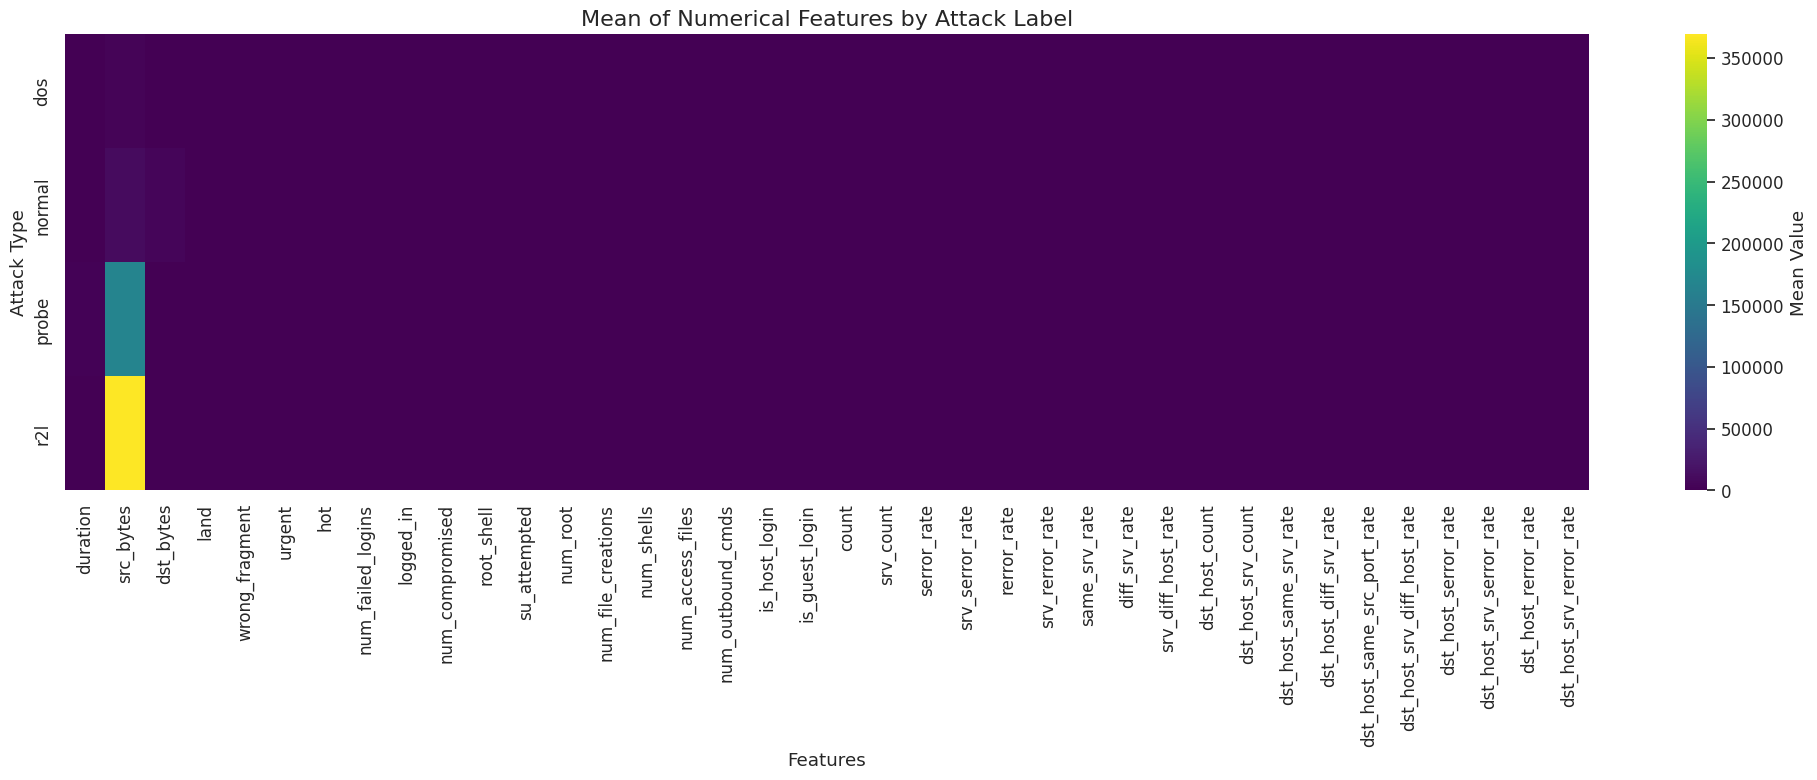

In [93]:
# --- Mean heatmap ---

# We use the *original* train_df for this analysis, not the scaled one.
# We only select the numerical columns (including 0/1 features)

numerical_data = train_df[numerical_cols + ['label']]

# Group by attack label and calculate the mean
mean_heatmap_data = numerical_data.groupby('label').mean()

# Plot the heatmap
fig_mean, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(
    mean_heatmap_data,
    annot=False,
    fmt=".2f",
    cmap='viridis',
    ax=ax,
    cbar_kws={'label': 'Mean Value'}
)
ax.set_title('Mean of Numerical Features by Attack Label', fontsize=16)
ax.set_xlabel('Features')
ax.set_ylabel('Attack Type')
plt.tight_layout()

# Save the plot
save_plot(fig_mean, "task1_mean_heatmap", path=save_dir, close_fig=False)
plt.show()

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/task1_std_dev_heatmap.png


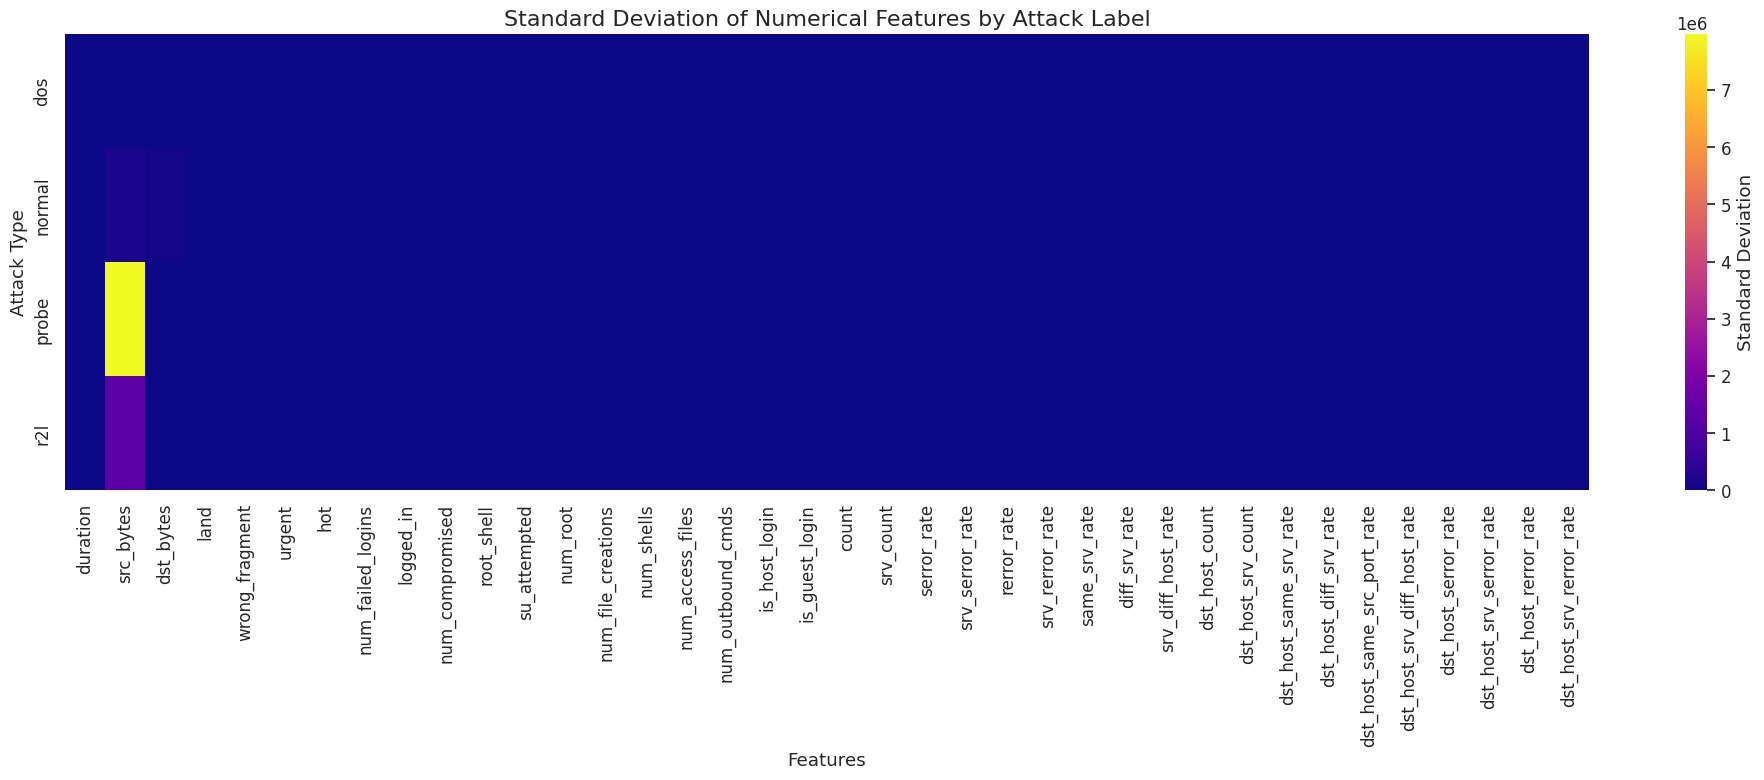

In [94]:
# --- Standard Deviation heatmap ---

# We re-use the 'numerical_data' dataframe from the previous cell

# Group by attack label and calculate the standard deviation
std_heatmap_data = numerical_data.groupby('label').std()

# Plot the heatmap
fig_std, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(
    std_heatmap_data,
    annot=False,
    fmt=".2f",
    cmap='plasma',
    ax=ax,
    cbar_kws={'label': 'Standard Deviation'}
)
ax.set_title('Standard Deviation of Numerical Features by Attack Label', fontsize=16)
ax.set_xlabel('Features')
ax.set_ylabel('Attack Type')
plt.tight_layout()

# Save the plot
save_plot(fig_std, "task1_std_dev_heatmap", path=save_dir, close_fig=False)
plt.show()

Saved plot: /content/drive/MyDrive/Projects/AImSecure/Laboratory3/results/images/task1_plots/task1_median_heatmap.png


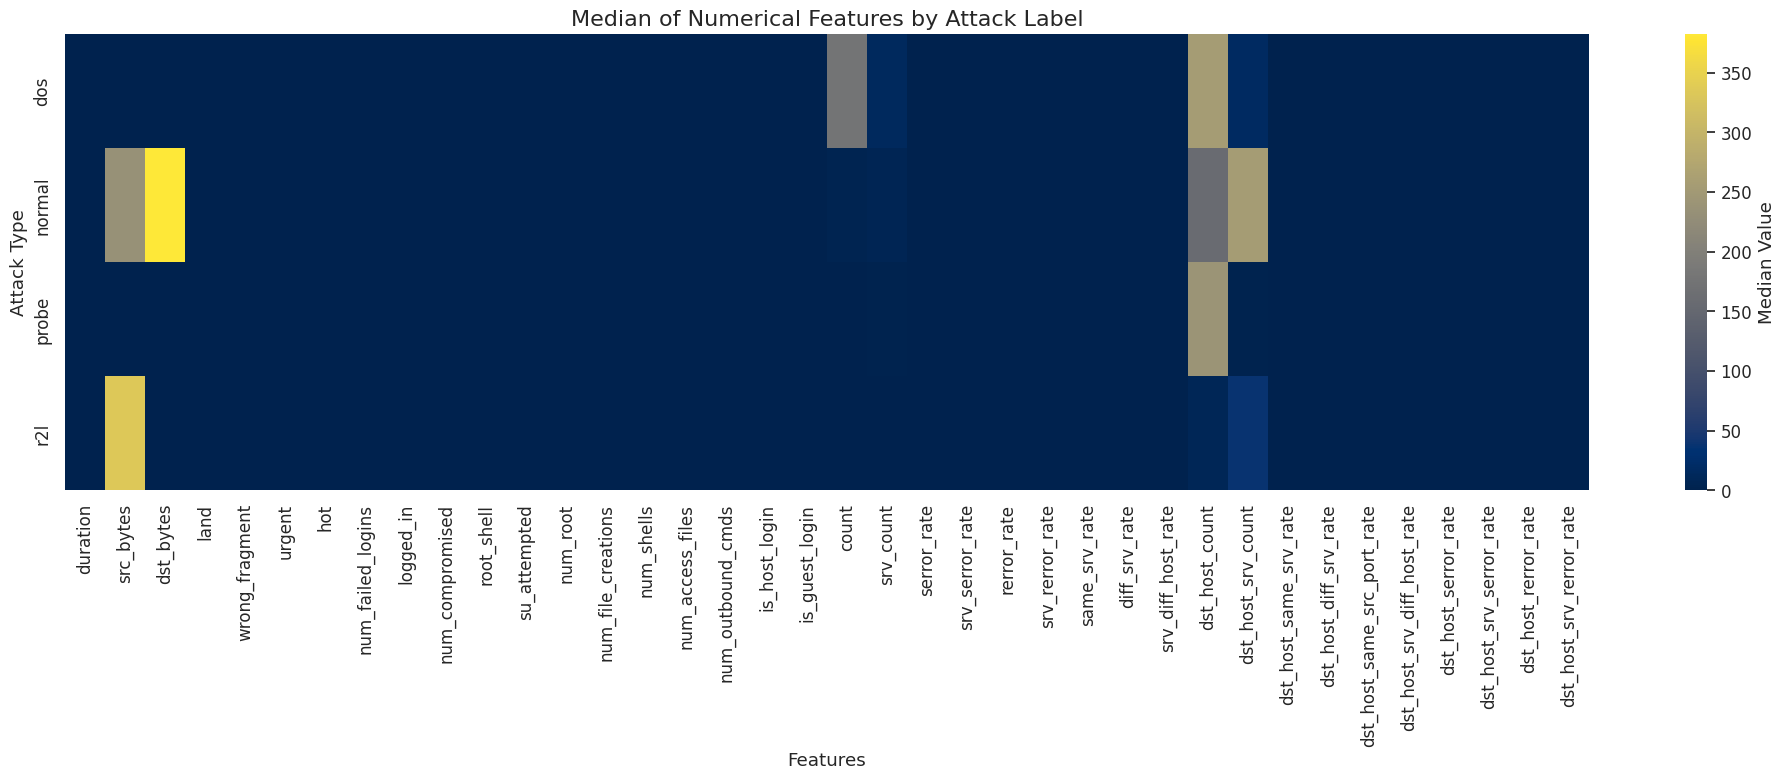

In [95]:
# --- Median Heatmap ---

# We re-use the 'numerical_data' dataframe from the previous cell

# Group by attack label and calculate the median
median_heatmap_data = numerical_data.groupby('label').median()

# Plot the heatmap
fig_median, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(
        median_heatmap_data,
        annot=False,
        fmt=".2f",
        cmap='cividis',
        ax=ax,
        cbar_kws={'label': 'Median Value'}
)
ax.set_title('Median of Numerical Features by Attack Label', fontsize=16)
ax.set_xlabel('Features')
ax.set_ylabel('Attack Type')
plt.tight_layout()

# Save the plot
save_plot(fig_median, "task1_median_heatmap", path=save_dir, close_fig=False)
plt.show()

#### Q: Looking at the different heatmaps, do you find any main characteristics that are strongly correlated with a specific attack?

TODO

## Task 2 - Shallow Anomaly Detection - Supervised vs Unsupervised

text

In [96]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task2_plots/'
os.makedirs(save_dir, exist_ok=True)

### One-Class SVM with Normal data only

First, train a One-Class Support Vector Machine (OC-SVM) with benign (normal) traffic only using an rbf kernel. Then, evaluate the performance using all training data (normal + anomalies).

In [97]:
# [CODE BLOCK]
# 1. Filter the preprocessed training data to get 'normal' samples only
# 2. Define two OC-SVM models (rbf kernel):
#    - Model 1: Use your estimated 'nu'
#    - Model 2: Use the default 'nu'
# 3. Train both models on normal data only
# 4. Evaluate both models on the *full* training set (normal + anomalies)
# 5. Report classification report (precision, recall, f1-score)

#### Q: Considering that you are currently training only on normal data, which is a good estimate for the parameter $nu^{2}$? What is the impact on training performance? Try both your estimate and the default value of nu.

TODO

### One-Class SVM with All data

Now train the OC-SVM with both normal and anomalous data. Estimate nu as the ratio of anomalous data across the entire collection. Then, evaluate the performance.

In [98]:
# [CODE BLOCK]
# 1. Calculate 'nu' as the ratio of anomalies in the full training set
# 2. Train a new OC-SVM (rbf kernel) on the *full* training set using this 'nu'
# 3. Evaluate the model on the full training set
# 4. Report classification report

#### Q: Which model performs better? Why do you think that?

TODO

### One-Class SVM with normal traffic and some anomalies

Evaluate the impact of the percentage of anomalies while training. Train several OC-SVMs with an increasing subsample of anomalous classes (10%, 20%, 50%, 100% of anomalies). Estimate the nu parameter for each scenario.

In [99]:
# [CODE BLOCK]
# 1. Get all normal data
# 2. Get all anomalous data
# 3. Create a loop for percentages [0.1, 0.2, 0.5, 1.0]
# 4. In the loop:
#    - Subsample the anomalous data based on the percentage
#    - Combine with all normal data to create a new training subset
#    - Calculate 'nu' for this subset (ratio of anomalies)
#    - Train an OC-SVM on this subset
#    - Evaluate the trained model on the *full* training set (normal + all anomalies)
#    - Store the f1-macro score
# 5. Plot the f1-macro scores against the anomaly percentages

#### Q: Plot the f1-macro score for each scenario. How does the increasing ratio of anomalies affect the results?

TODO

### Robustness of the One-Class SVM model

Finally, use the test set to assess the robustness. [cite: 106] Use models trained with:
1. Only normal data
2. All data
3. 10% of anomalous data

In [100]:
# [CODE BLOCK]
# 1. Take the three models trained previously (from point 1, 2, and 3 of Task 2)
# 2. Evaluate each of them on the *preprocessed test set*
# 3. For each model, print the classification report and a confusion matrix

#### Q: Is the best-performing model in the training set also the best here? Does it confuse normal data with anomalies? Which attack is the most confused?

TODO

## Task 3 - Deep Anomaly Detection and Data Representation

text

In [101]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task3_plots/'
os.makedirs(save_dir, exist_ok=True)

### Training and Validating Autoencoder with Normal data only

Create an Autoencoder with a shrinking encoder and an expansion decoder. Use normal data only; split into training and validation sets.

In [102]:
# [CODE BLOCK]
# 1. Get the preprocessed 'normal' data from the training set
# 2. Split this normal data into a new AE-training set and an AE-validation set (e.g., 80/20 split)
# 3. Define the Autoencoder (AE) architecture using Keras/TensorFlow
#    - Shrinking encoder
#    - Bottleneck layer
#    - Expansion decoder
# 4. Compile the model (e.g., optimizer='adam', loss='mse')
# 5. Train the model using the AE-training set and validate on the AE-validation set
# 6. Use callbacks like EarlyStopping to find the best number of epochs
# 7. Plot the training and validation loss curves

### Estimate the Reconstruction Error Threshold

Estimate a threshold using the reconstruction error on the validation set. Plot the ECDF curve.

In [103]:
# [CODE BLOCK]
# 1. Get predictions (reconstructions) for the AE-validation set
# 2. Calculate the reconstruction error (e.g., MSE) for each sample in the validation set
# 3. Plot the ECDF (Empirical Cumulative Distribution Function) of these errors
# 4. Choose a threshold based on the ECDF (e.g., 95th or 99th percentile)

#### Q: How did you pick the threshold? What is its value?

TODO

### Anomaly Detection with reconstruction error

Use the trained model and threshold to classify anomalies in the full training set and test set.

In [104]:
# [CODE BLOCK]
# 1. Calculate reconstruction errors for:
#    - i) AE-validation set (already done)
#    - ii) Full training set (normal + anomalies)
#    - iii) Full test set
# 2. Plot the ECDFs for all three sets of errors on one graph
# 3. Using the threshold from the previous step:
#    - Classify anomalies in the full training set
#    - Classify anomalies in the test set
# 4. Report classification reports for both

#### Q: Plot and report the ECDF... Why the reconstruction errors higher on the full training set than on the validation one? And why are the reconstruction errors in the test set even higher? How is the performance on the training... and test set?

TODO

### Auto-Encoder's bottleneck and OC-SVM

Use the encoder's bottleneck for data representation. Train an OC-SVM on the bottleneck embeddings of the normal data.

In [105]:
# [CODE BLOCK]
# 1. Create an 'encoder' model from the trained AE (inputs -> bottleneck layer)
# 2. Extract bottleneck embeddings for the *normal* training data
# 3. Train a new OC-SVM on these normal data embeddings (like in Task 2.1)
# 4. Extract bottleneck embeddings for the *full test set*
# 5. Use the trained OC-SVM to predict anomalies on the test embeddings
# 6. Report the classification report for the test set

#### Q: Compare the results with the best original OC-SVM and with the Autoencoder with reconstruction error. Describe the performance...

TODO

### PCA and OC-SVM

Use PCA for data representation. Analyze the explained variance on normal data only.

In [106]:
# [CODE BLOCK]
# 1. Use the preprocessed *normal* training data
# 2. Fit PCA on this data (try a large number of components first, e.g., n_components=0.99)
# 3. Plot the cumulative explained variance vs. number of components
# 4. Identify the 'elbow point' or the number of components explaining (e.g.) 95% of the variance
# 5. Fit and transform the normal training data with this 'best' number of components
# 6. Transform the *full test set* with the *same fitted PCA*
# 7. Train an OC-SVM on the PCA-transformed normal training data
# 8. Evaluate this OC-SVM on the PCA-transformed test set
# 9. Report classification report

#### Q: compare results with the original OC-SVM and the OC-SVM trained using the Encoder embeddings. Describe the performance...

TODO

## Task 4 - Unsupervised Anomaly Detection and Interpretation

text

In [107]:
# Create directory for plots
save_dir = results_path + 'images/' + 'task4_plots/'
os.makedirs(save_dir, exist_ok=True)

### K-means with little domain knowledge

Fit k-means with 4 clusters and the full training data (normal + anomalous). (Normal + 3 attack types = 4 clusters).

In [108]:
# [CODE BLOCK]
# 1. Use the *full preprocessed training data*
# 2. Fit a KMeans model with n_clusters=4
# 3. Get the cluster assignments (labels) for all training data

### K-means cluster interpretation

Examine the clusters to understand their quality.

In [109]:
# [CODE BLOCK]
# 1. Add the K-means cluster labels to the training dataframe (which has the real attack labels)
# 2. Calculate and print the size of each cluster
# 3. Create a contingency table (crosstab) of K-means clusters vs. true 'attack_label'
# 4. Calculate silhouette scores per cluster

#### Q: How big are the clusters? How are the attack labels distributed across the clusters? Are the clusters pure?

TODO

#### Q: How high is the silhouette per cluster? Is there any clusters with a lower silhouette value? If it is the case, what attack labels are present in these clusters?

TODO

#### Q: Use the t-SNE algorithm... Plot and report: i) t-SNE... with cluster ID. ii) t-SNE... with the attack label.

TODO

In [110]:
# [CODE BLOCK]
# 1. Run t-SNE on the full training data (n_components=2)
#    - Try a few perplexity values (e.g., 30, 50, 100)
# 2. Choose the best-looking perplexity
# 3. Plot 1: 2D t-SNE scatter plot, colored by *K-means cluster ID*
# 4. Plot 2: 2D t-SNE scatter plot, colored by *true attack_label*

#### Q: Can you find a difference between the two visualizations? What are the misinterpreted points?

TODO

### DB-Scan anomalies are anomalies?

Use DB-Scan to detect anomalous patterns.

In [111]:
# [CODE BLOCK]
# 1. Determine 'min_points'
#    - (Justify your choice. e.g., "From the k-means analysis, the smallest 'pure' normal cluster was not found. We will set min_points=... based on domain knowledge/heuristics...")
# 2. Determine 'eps' (e) using the elbow rule
#    - Calculate distance to the k-th nearest neighbor (k=min_points)
#    - Sort and plot these distances
#    - Find the 'elbow' (point of max curvature)
# 3. Run DBSCAN on the full training set with your chosen 'eps' and 'min_points'
# 4. Get the DBSCAN cluster labels (includes -1 for noise)
# 5. Check the noise cluster (label -1)
# 6. Create a crosstab of DBSCAN cluster labels vs. true 'binary_label' (0=normal, 1=anomaly)

#### Q: Create the clustering results... Does the DB-Scan noise cluster (cluster -1) consist only of anomalous points (cross-reference with real attack labels)?

TODO

---